# Data Collection
The dataset examined here was obtained from https://www.census.gov/data/developers/data-sets/Poverty-Statistics.html, and provides small area income and poverty esitmates (SAIPE) of income and poverty statistics from states. The data aims to provide estimates of income and poverty for the administration of federal programs.

The data was collected through an API call from census.gov. The code for the API implementation is given below. This dataset is relevant to our research questions since we are interested in determining if PFAs contamination have any correlation with poverty levels, as well as region. It also provides insight into population/density features and their relationship with poverty levels, which may also provide further details on the risk of PFAs.

In [14]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from scipy import stats
import seaborn as sns

In [2]:
#API REQUEST TO GET POVERTY DATA

url = "https://api.census.gov/data/timeseries/poverty/saipe"
params = {
    #SPECFIC VARIABLES OF INTEREST - Ensuring Project Relevance
    "get": "NAME,SAEMHI_PT,SAEPOV0_17_PT,SAEPOVRT0_17_PT,SAEPOVALL_PT,SAEPOVRTALL_PT,SAEPOVU_0_17,SAEPOVU_ALL,STABREV,STATE,YEAR",
    "for": "state:*",
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
else:
    print(f"Request failed with status code {response.status_code}")

# CREATE DATA FRAME
df = pd.DataFrame(data[1:], columns=data[0])

# Data Cleaning and Preprocessing

## Understanding the Data

The following code cleans this dataset to make it more suitable for further analysis. Missing values, duplicates, or any outliers are assessed along with updating the dataset to include more interpretable column names and only include relevant years in relation to the other dataset used (EPA data). It also assess the data for completeness, consistency, and usability.

In [3]:
# Making Column Names more interpretable
df = df.rename(columns={'SAEMHI_PT': 'Median_Income',
                        'SAEPOV0_17_PT': 'Child_Poverty_Count',
                        'SAEPOVRT0_17_PT': 'Child_Poverty_Rate',
                        'SAEPOVALL_PT': 'Poverty_Count',
                        'SAEPOVRTALL_PT': 'Poverty_Rate',
                        'SAEPOVU_0_17': 'All_Child_Poverty_Count',
                        'SAEPOVU_ALL': 'All_Poverty_Count'})

# Drop redundant Columns
df = df.drop(columns = [ 'state' ])


# Convert Columns to proper data type
exclude_columns = ['NAME', 'STABREV']
columns_to_convert = [col for col in df.columns if col not in exclude_columns]
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce', downcast='integer')

# Filter for relevant years
years_of_interest = [2013, 2014, 2015, 2018, 2019, 2020, 2023]
df = df[df['YEAR'].isin(years_of_interest)]

#Exaimining Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357 entries, 1020 to 1580
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NAME                     357 non-null    object 
 1   Median_Income            357 non-null    int32  
 2   Child_Poverty_Count      357 non-null    int32  
 3   Child_Poverty_Rate       357 non-null    float64
 4   Poverty_Count            357 non-null    int32  
 5   Poverty_Rate             357 non-null    float64
 6   All_Child_Poverty_Count  357 non-null    float64
 7   All_Poverty_Count        357 non-null    float64
 8   STABREV                  357 non-null    object 
 9   STATE                    357 non-null    int8   
 10  YEAR                     357 non-null    int16  
dtypes: float64(4), int16(1), int32(3), int8(1), object(2)
memory usage: 24.8+ KB


In [4]:
#Exaimine NA Values
df.isna().sum().sum()

#Resolved

0

## Basic Statistical Analysis

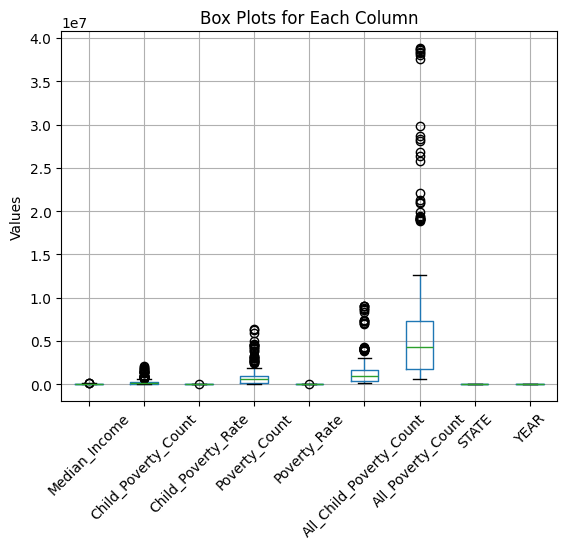

In [6]:
# Quick look for Outliers

df.boxplot()
plt.title('Box Plots for Each Column')
plt.ylabel('Values')
plt.xticks(rotation = 45)
plt.show()

In [7]:
#Exaiming Poverty Rate Outliers

#Based upon Z-score
df['Z_score'] = (df['Poverty_Rate'] - df['Poverty_Rate'].mean()) / df['Poverty_Rate'].std()
outliers_z = df[np.abs(df['Z_score']) > 2]
outliers_z

,NAME,Median_Income,Child_Poverty_Count,Child_Poverty_Rate,Poverty_Count,Poverty_Rate,All_Child_Poverty_Count,All_Poverty_Count,STABREV,STATE,YEAR,Z_score
1038,Louisiana,44234,311059,28.4,897284,20.0,1097099.0,4494987.0,LA,22,2013,2.138629
1044,Mississippi,38191,246458,34.0,692058,23.9,725052.0,2893762.0,MS,28,2013,3.384440
1051,New Mexico,44026,151127,30.1,437923,21.4,502248.0,2045405.0,NM,35,2013,2.585843
1089,Louisiana,44680,307469,28.0,898902,19.9,1097124.0,4518537.0,LA,22,2014,2.106685
1095,Mississippi,39738,220885,30.7,634960,21.9,719646.0,2895486.0,MS,28,2014,2.745562
1102,New Mexico,44905,138918,28.0,420388,20.6,496465.0,2045506.0,NM,35,2014,2.330292
1146,Mississippi,40630,225347,31.5,638919,22.1,715914.0,2896612.0,MS,28,2015,2.809450
1153,New Mexico,45524,133471,27.2,405364,19.8,490693.0,2044455.0,NM,35,2015,2.074741
1299,Mississippi,44740,195794,28.2,571402,19.8,694588.0,2886375.0,MS,28,2018,2.074741
1406,New Hampshire,81415,20726,8.4,92404,7.0,247828.0,1325241.0,NH,33,2020,-2.014074


After collecting the data it is apparent that there are some outliers in the data, but given the lack of overly extreme values, it is likely that all rates are legitimate for further analysis.

In [11]:
#Summary Statistics
df.describe()

,Median_Income,Child_Poverty_Count,Child_Poverty_Rate,Poverty_Count,Poverty_Rate,All_Child_Poverty_Count,All_Poverty_Count,STATE,YEAR,Z_score
count,357.000000,3.570000e+02,357.000000,3.570000e+02,357.000000,3.570000e+02,3.570000e+02,357.000000,357.000000,3.570000e+02
mean,62332.963585,2.644844e+05,17.775350,8.505579e+05,13.305042,1.411678e+06,6.219694e+06,28.960784,2017.428571,2.786442e-16
std,13156.595147,3.342090e+05,5.164769,1.018352e+06,3.130491,1.635515e+06,7.060394e+06,15.698838,3.336649,1.000000e+00
min,38191.000000,1.106100e+04,7.500000,5.241800e+04,7.000000,1.096300e+05,5.633450e+05,1.000000,2013.000000,-2.014074e+00
25%,51914.000000,5.594900e+04,13.600000,1.976260e+05,10.800000,3.702580e+05,1.734091e+06,16.000000,2014.000000,-8.002074e-01
50%,60794.000000,1.759950e+05,17.400000,5.850970e+05,12.800000,9.882870e+05,4.326301e+06,29.000000,2018.000000,-1.613300e-01
75%,70939.000000,3.006490e+05,21.300000,9.287780e+05,15.600000,1.610783e+06,7.259760e+06,42.000000,2020.000000,7.330984e-01
max,104643.000000,2.119056e+06,34.000000,6.328064e+06,23.900000,9.030489e+06,3.881853e+07,56.000000,2023.000000,3.384440e+00


After a brief glance at the summary statistics the following should be noted:
* There is positive skewness (right-skewed) distributions for some of the variables. Meaning that the mean is greater than the median. This is true for: `Child_Poverty_Count`, `Poverty_Count`, `All_Child_Poverty_Count`, and `All_Poverty_Count`.
* There is negative skewness (left-skewed) distributions, meaning the mean is less than the median, for `All_Child_Poverty_Count`. Other variables are similar in their mean and median, excluding `STATE`, and `YEAR`, which, while categorized as numeric variables, represent categorical data.

                         Median_Income  Child_Poverty_Count  \
Median_Income                 1.000000            -0.085621   
Child_Poverty_Count          -0.085621             1.000000   
Child_Poverty_Rate           -0.702354             0.310826   
Poverty_Count                -0.045669             0.991638   
Poverty_Rate                 -0.736614             0.272048   
All_Child_Poverty_Count       0.060240             0.970648   
All_Poverty_Count             0.080627             0.954353   
STATE                        -0.084099            -0.070154   
YEAR                          0.602348            -0.107281   
Z_score                      -0.736614             0.272048   

                         Child_Poverty_Rate  Poverty_Count  Poverty_Rate  \
Median_Income                     -0.702354      -0.045669     -0.736614   
Child_Poverty_Count                0.310826       0.991638      0.272048   
Child_Poverty_Rate                 1.000000       0.278286      0.979868   
Po

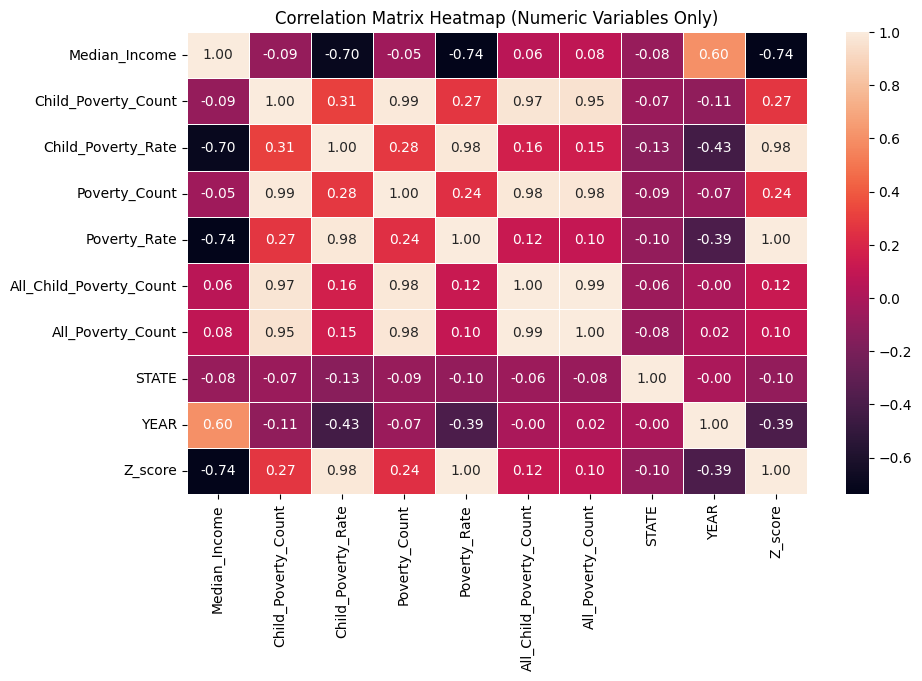

In [17]:
# Correlation table
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation table
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

# Visualize with heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix , annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap (Numeric Variables Only)")
plt.show()

After assessing the correlation table and the heat map, it appears that there are relatively strong (above -0.70) negative correlations between: `Child_Poverty_Rate` and `Median_Income`, and `Poverty_Rate` and `Median_Income`. This makes sense, since it is suggesting that higher income areas have lower poverty rates.

There are relatively strong (above 0.70) positive correlations between: `Child_Poverty_Count` and `All_Poverty_Count`, `Child_Poverty_Count` and `All_Child_Poverty_Count`, `Poverty_Rate` and `Child_Poverty_Rate`, `Poverty_Count` and `Child_Porverty_Count` and `All_Child_Poverty_Count` and `All_Poverty_Count`. These correlations also make sense given the economic expectations, since it is suggesting that child poverty and general poverty rise and fall together.

**(DATA SIMILARITY AND INTEGRATION WITH EPA NEEDED HERE)**

## Advanced Data Understanding

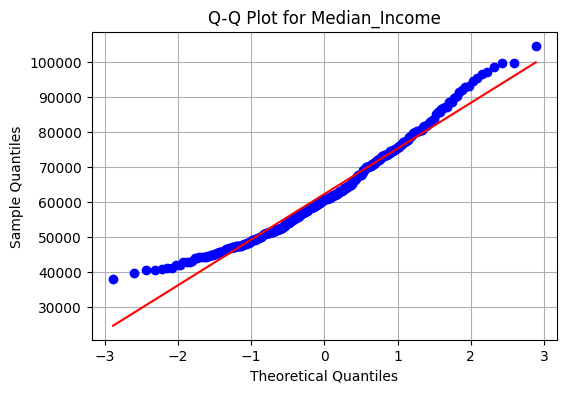

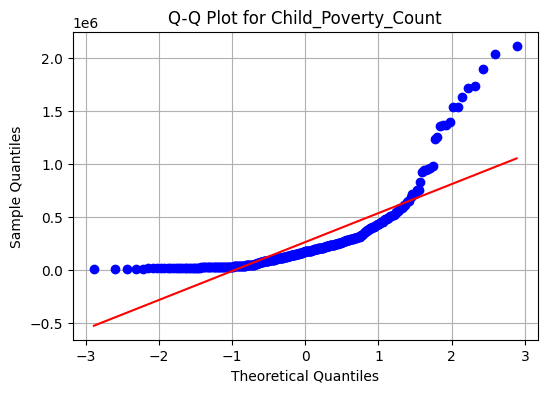

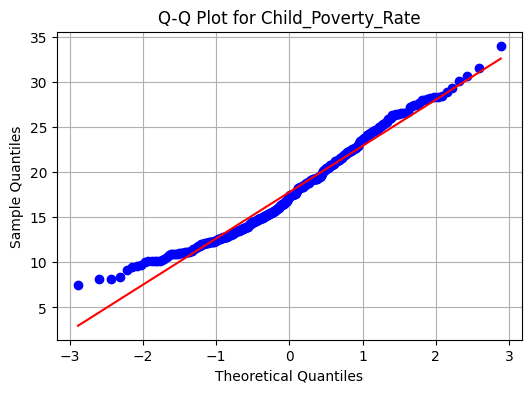

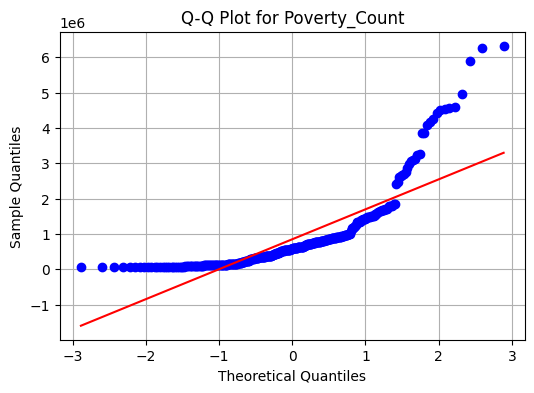

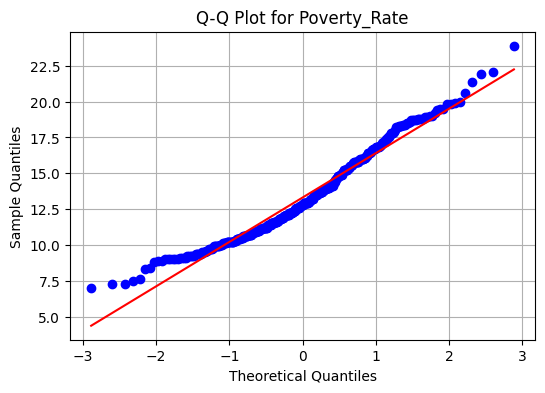

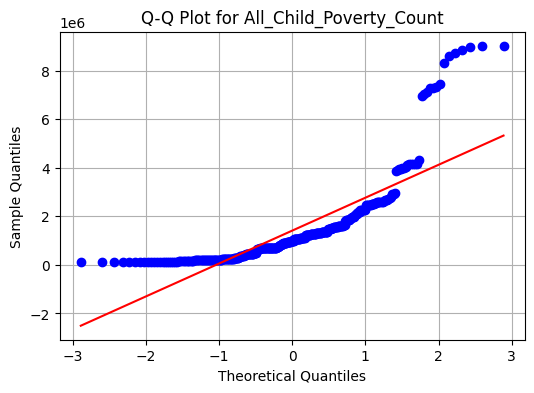

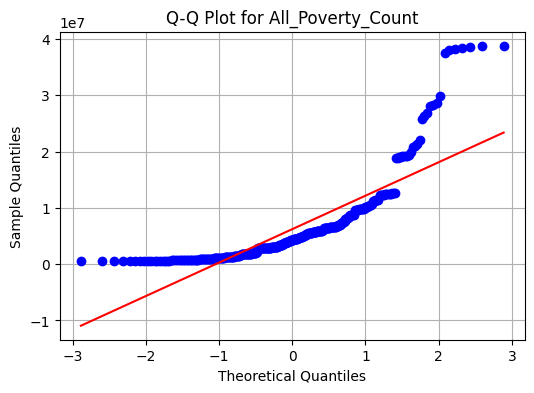

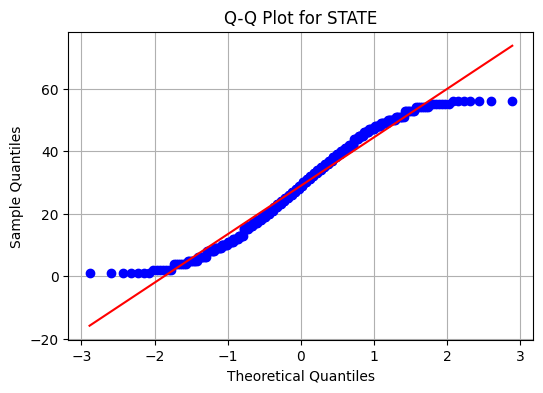

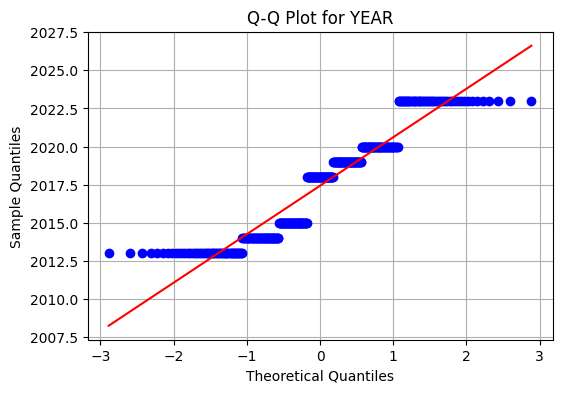

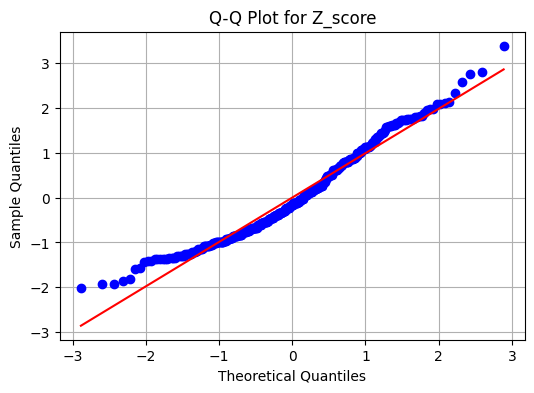

In [18]:
# Create Q-Q plots for each numeric variable
for col in numeric_df.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(numeric_df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

Q-Q Plot Interpretations:
* `Median_Income`- generally normally distributed, with some skewness in both the right and left tails.
* `Child_Poverty_Count` - not normally distributed, heavy skewness and likely follows a different distribution.
* `Child_Poverty_Rate` - generally normally distributed, some sknewness in the left tail.
* `Poverty_Count` - not normally distributed, heavy skewness and likely follows a different distribution.
* `Poverty_Rate` - generally normally distributed, some skewness in the left tail.
* `All_Child_Poverty_Count` - not normally distributed, heavy skewness and likely follows a different distribution.
* `All_Poverty_Count` - not normally distributed, heavy skewness and likely follows a different distribution.

## Visualizations

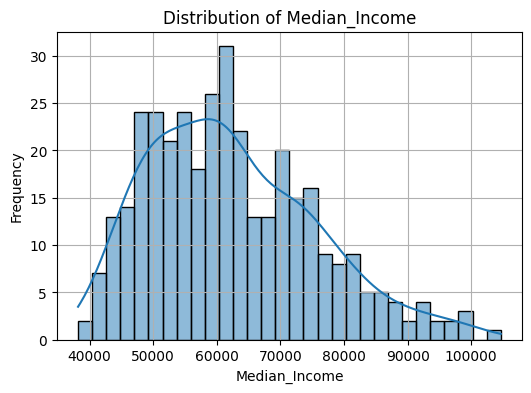

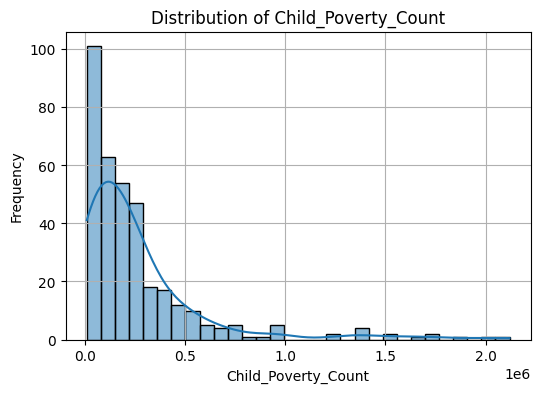

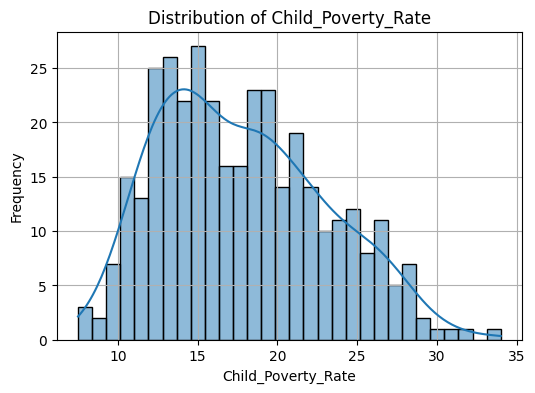

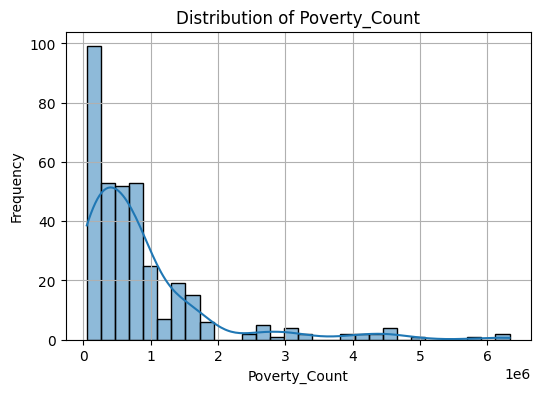

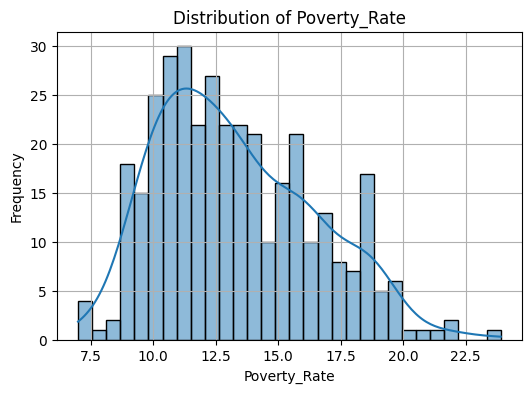

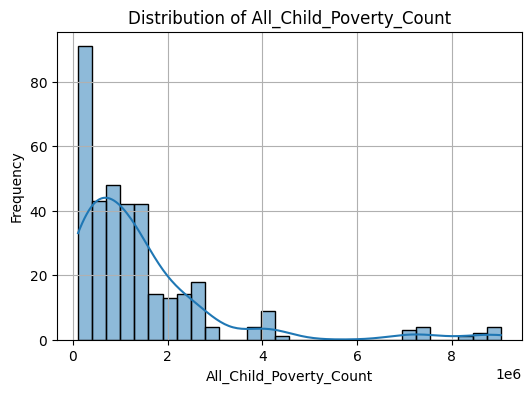

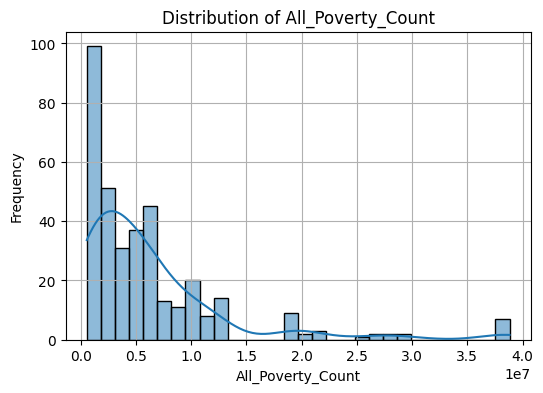

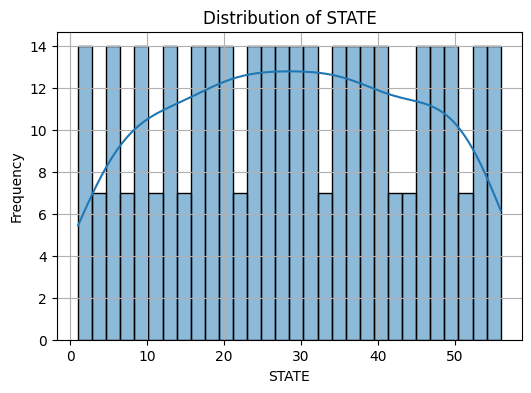

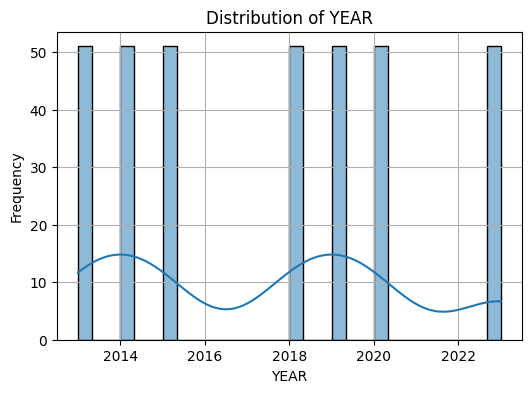

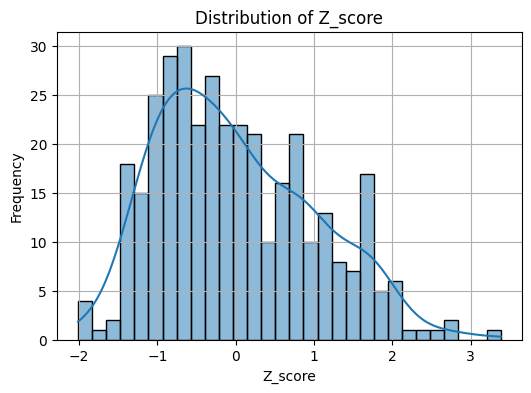

In [19]:
# Histograms of each variable
# Create histograms with KDE overlay
for col in numeric_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

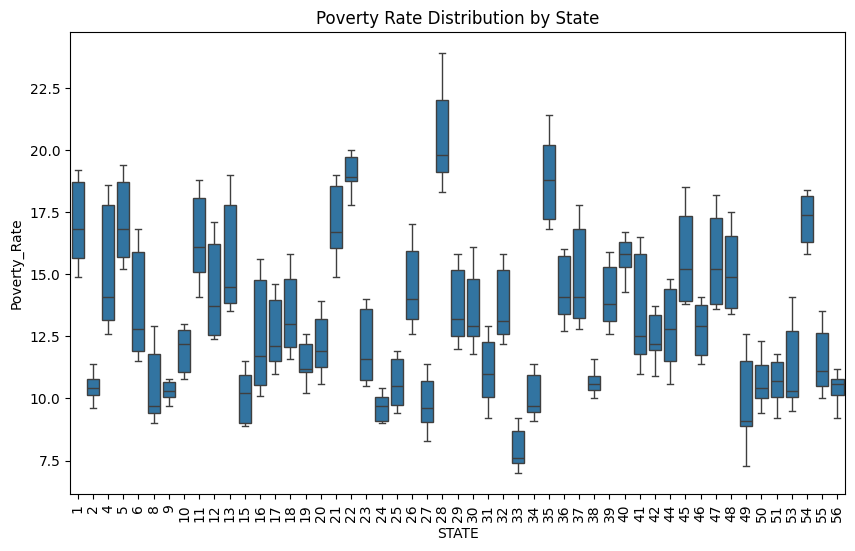

In [20]:
# Boxplots - assessing outliers of poverty rate by state
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["STATE"], y=df["Poverty_Rate"])
plt.xticks(rotation=90)
plt.title("Poverty Rate Distribution by State")
plt.show()

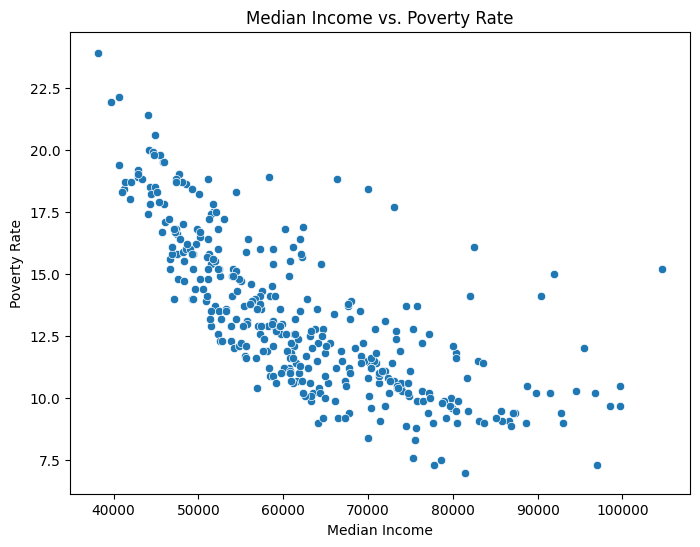

In [22]:
# Income versus poverty rate
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Median_Income"], y=df["Poverty_Rate"])
plt.title("Median Income vs. Poverty Rate")
plt.xlabel("Median Income")
plt.ylabel("Poverty Rate")
plt.show()

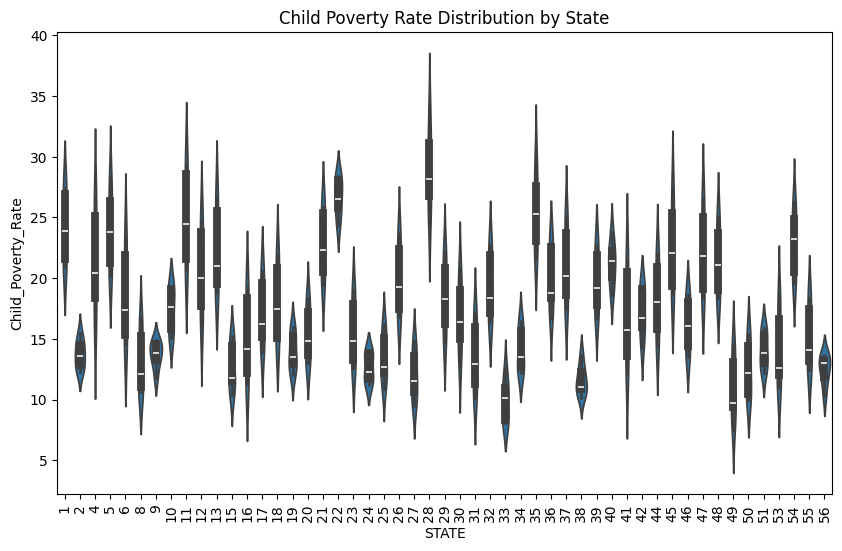

In [23]:
# Child poverty rate by state - violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=df["STATE"], y=df["Child_Poverty_Rate"])
plt.xticks(rotation=90)
plt.title("Child Poverty Rate Distribution by State")
plt.show()